<center>
<h3>Universidade Federal do Rio Grande do Sul (UFRGS)<br>
Programa de Pós-Graduação em Engenharia Civil (PPGEC)<br>
PEC00144 - Métodos Experimentais em Engenharia Civil</h3>

<h1>Trabalho 5</h1>

<h3>Aluno: <a href="https://github.com/dutitello/">Eduarto Pagnussat Titello</a></h3>

</center>


Este trabalho tem por objetivo: fazer uma aquisição com o MPU6050 preso com dupla face numa régua em balanço e apresentar resultado no tempo e na frequência. Determinar a frequência natural no modo fundamental da régua.

In [1]:
# Importando e configurando módulos
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' # Muda backend do jupyter para SVG ;)
import jupyter2latex as j2l # Uma maneira que encontrei para tabelas ficarem ok (github.com/dutitello/Jupyter2Latex)
from MRPy import MRPy
import serial
import time

# Configuração do experimento

No experimento é utilizada uma régua de alumínio com 53 cm de comprimento e 2,5 cm de largura, onde o comprimento em balanço é 50 cm. A configuração é apresentada na figura \ref{fig:conf}.

\begin{figure}
\includegraphics[width=8cm]{./imagens/conf1}
\centering
\label{fig:conf}
\end{figure}

Os eixos do acelerômetro são posicionados conforme apresentado na figura \ref{fig:eixos}.

\begin{figure}
\includegraphics[width=8cm]{./imagens/PosEixos}
\centering
\label{fig:eixos}
\end{figure}

# Leitura e processamento das acelerações 

Para leitura e processamento das acelerações são empregados os códigos desenvolvidos por Rocha (2020), onde são introduzidas pequenas alterações. Essencialmente os códigos são transformados em uma única função onde os dados são lidos, reescalados e reamostrados, fixando o *time step*.

In [45]:
def Acelr(nlines, port='COM3', baud=115200):
    # Inicia conexão
    Ardn  =  serial.Serial(port, baud, timeout=1)

    # Função que faz leitura 
    def ReadSerial(nchar, nvar, nlines):
        Ardn.write(str(nlines).encode())
        data = np.zeros((nlines,nvar))
        for k in range(nlines):
            wait = True
            while(wait):
                if (Ardn.inWaiting() >= nchar):
                    wait = False
                    bdat = Ardn.readline() 
                    sdat = bdat.decode()
                    sdat = sdat.replace('\n',' ').split()
                    data[k, :] = np.array(sdat[0:nvar], dtype='int')
        return data

    # Precisa deixar tipo 1 segundo para realizar conexão.
    # No caso aumentei o tempo para facilitar na hora da excitação. 
    # OBS: A luz TX do arduino acende quando a conexão está ligada!
    print("Wait for it...")
    time.sleep(3)
    print("Reading, go!")

    try:
        data = ReadSerial(30, 4, nlines)
        t    = data[:,0 ]
        acc  = data[:,1:]

        Ardn.close()
        print('Acquisition ok!')
        
        # Ajusta escala dos dados
        ti  = (t - t[0])/1000
        a   =  2*9.81*acc/2**15
        # Fixa tamaho do timestep 
        data = MRPy.resampling(ti, a)
        print('Average sampling rate is {0:5.1f}Hz.'.format(data.fs))
        # Entrega dados processados
        return data
        
    except:
        Ardn.close()
        sys.exit('Acquisition failure!')

Aplicando um deslocamento inicial de 2 cm (além da flecha) na ponta da régua, são medidas as acelerações:

In [135]:
data = Acelr(15_000)

Wait for it...
Reading, go!
Acquisition ok!
Average sampling rate is 349.4Hz.


Plotando as acelerações (nas 3 direções) pelo tempo tem-se:

[[<matplotlib.lines.Line2D at 0x2b101b25400>],

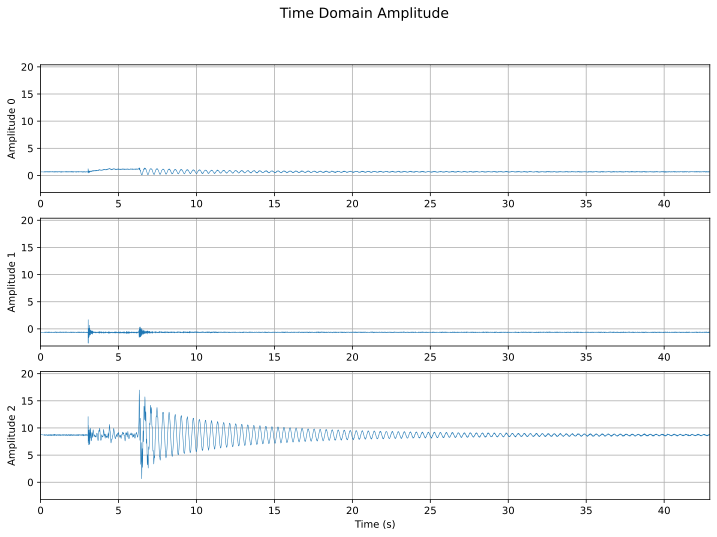

In [193]:
data.plot_time(figsize=(12,8))

Nos segundos iniciais, previamente à excitação, observam-se acelerações constantes e diferentes de zero nos três eixos. Essas se devem principalmente à inclinação do equipamento na ponta da régua, que apresenta uma flecha de cerca de 1 cm apenas com o peso da régua, do acelerômetro e do cabo. 

A fim de medir apenas acelerações relativas ao movimento dinâmico da régua é subtraído de cada eixo seu valor médio, assim:

[[<matplotlib.lines.Line2D at 0x2b100a560a0>],

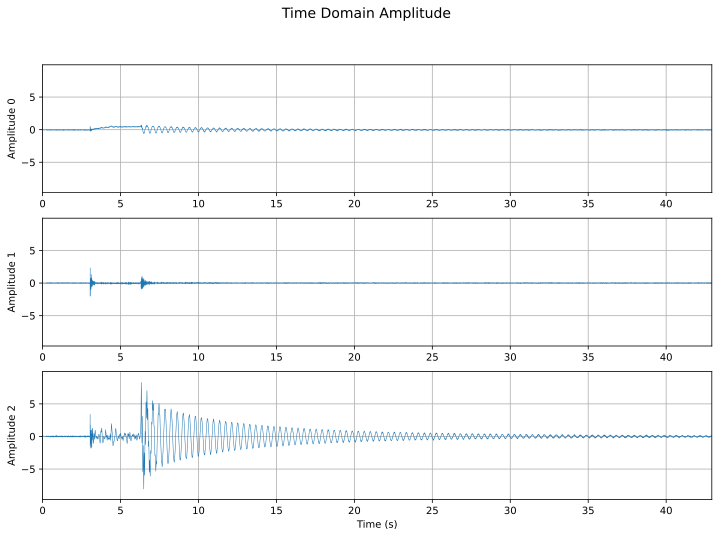

In [191]:
mean = data.mean(axis=1)
acel = data - np.array([mean]).T
acel.plot_time()

Desprezando as acelerações no segundo eixo (Y), perpendicular ao plano de interesse, o movimento oscilatório da ponta da régua é observado nos eixos Z (vertical) e X (axial).

# Determinação da frequência fundamental

Para determinação da frequência fundamental do sistema são plotadas as densidades espectrais das acelerações medidas, obtidas pelo periodograma:

[[<matplotlib.lines.Line2D at 0x2b101c8a220>],

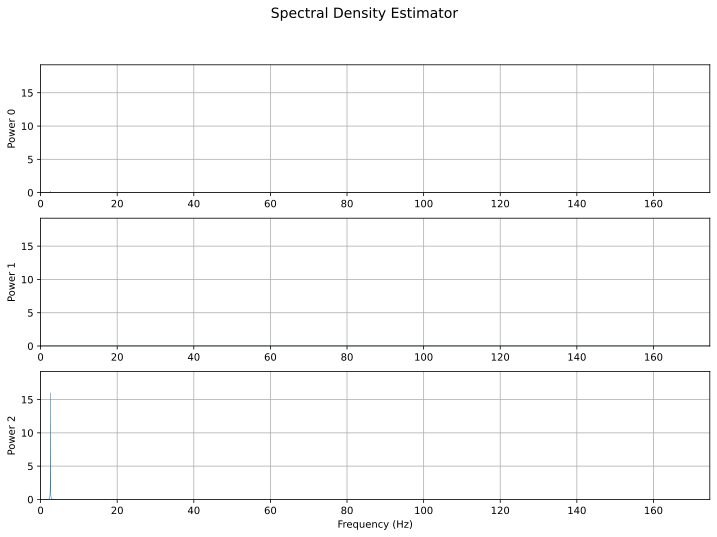

In [194]:
acel.plot_freq()

Observa-se que apenas um modo de vibração, de frequência de cerca de 2Hz, foi excitado. Aproximando a região tem-se:

[[<matplotlib.lines.Line2D at 0x2b100950280>],

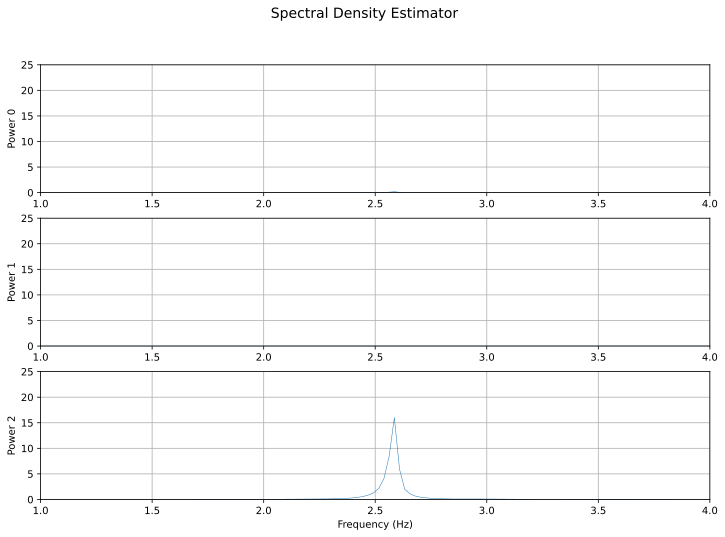

In [190]:
acel.plot_freq(axis_f=(1,4,0,25))

Logo a frequência fundamental é cerca de **2.6 Hz. **

# Determinação do deslocamento

Integrando as acelerações medidas duas vezes obtem-se os deslocamentos na ponta da régua. Filtrando apenas sinais no intervalo de 1 a 5 Hz tem-se:

[[<matplotlib.lines.Line2D at 0x2b17d077550>],

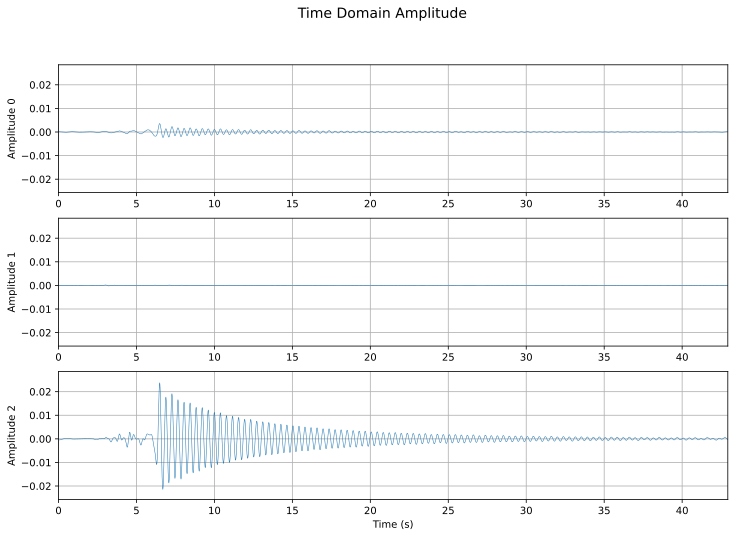

In [153]:
banda = [1, 5]
desl = (acel.integrate(band=banda)).integrate(band=banda)
desl.plot_time()

Observam-se deslocamentos de cerca de 2 cm, conforme o deslocamento inicial imposto. 